# PCA Visualization

#### Imports

In [1]:
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

C:\Users\haley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the Dataset

In [2]:
xset = np.load("Xset.npy")  # Shape: (num_images, 128, 128)
yset = np.load("Yset.npy")  # Shape: (num_images, num_classes=10)

lego_Y_labels = [3001, 3003, 3023, 3794, 4150, 4286, 6632, 18654, 43093, 54200]

x_train, x_test, y_train, y_test = train_test_split(xset, yset, test_size=0.3, random_state=42, shuffle=True)

# Results
print(f"Training set: X={x_train.shape}, Y={y_train.shape}")
print(f"Testing set: X={x_test.shape}, Y={y_test.shape}")

Training set: X=(5600, 128, 128), Y=(5600, 10)
Testing set: X=(2400, 128, 128), Y=(2400, 10)


In [3]:
subset_size = int(0.7*len(x_train))  # For example, take 100 images

# Randomly select indices
indices = np.random.choice(len(x_train), size=subset_size, replace=False)

# Select the subset based on the indices
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

np.save("x_train_subset.npy", x_train_subset)
np.save("y_train_subset.npy", y_train_subset)

#### PCA Visual of Images in 2D Space

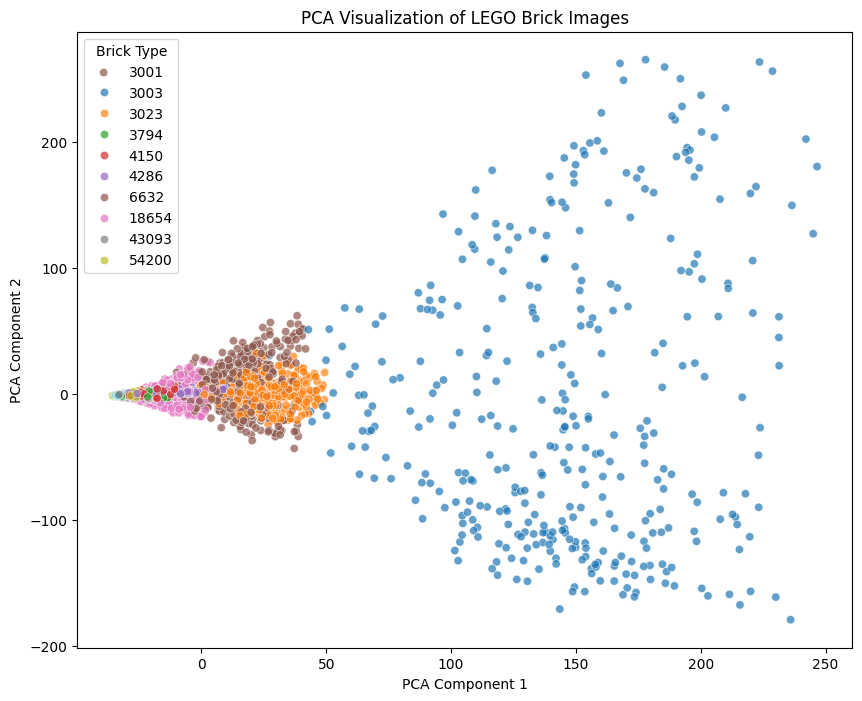

In [4]:
# Flatten each image into a 1D vector (from 128x128 to 16384)
num_samples = x_train_subset.shape[0]
flattened_images = x_train_subset.reshape(num_samples, -1) 

# Convert one-hot encoded labels back to class indices
labels = np.argmax(y_train_subset, axis=1) 

# Standardize the image data for better PCA performance
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_images_scaled)

# Plot the PCA visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of LEGO Brick Images")
plt.legend(lego_Y_labels, title="Brick Type")
plt.show()


#### PCA Visual of Image Embeddings

##### Create and Train Neural Network on Dataset

In [5]:
# Convert to torch tensors
x_train = torch.tensor(x_train_subset, dtype=torch.float32).unsqueeze(1) / 255.0  # Normalize & add channel dim
y_train = torch.tensor(y_train_subset, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = data.TensorDataset(x_train, y_train)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
class LegoCNN(nn.Module):
    def __init__(self, num_classes):
        super(LegoCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Fully connected layer (embedding layer)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer
        
    def forward(self, x, return_embedding=False):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # (Batch, 32, 64, 64)

        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # (Batch, 64, 32, 32)

        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))  # Embedding layer (128-dimensional)

        if return_embedding:
            return x  # Return only embeddings

        x = self.fc2(x)  # Final output layer
        return x



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = y_train.shape[1]
model = LegoCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Model outputs logits
        
        loss = criterion(F.softmax(outputs, dim=1), labels)  # Apply softmax to outputs
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


print("Training complete!")


Epoch [1/10], Loss: 0.0574
Epoch [2/10], Loss: 0.0400
Epoch [3/10], Loss: 0.0323
Epoch [4/10], Loss: 0.0247
Epoch [5/10], Loss: 0.0204
Epoch [6/10], Loss: 0.0167
Epoch [7/10], Loss: 0.0146
Epoch [8/10], Loss: 0.0130
Epoch [9/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0094
Training complete!


##### Extract embeddings from Neural Network for PCA Visual

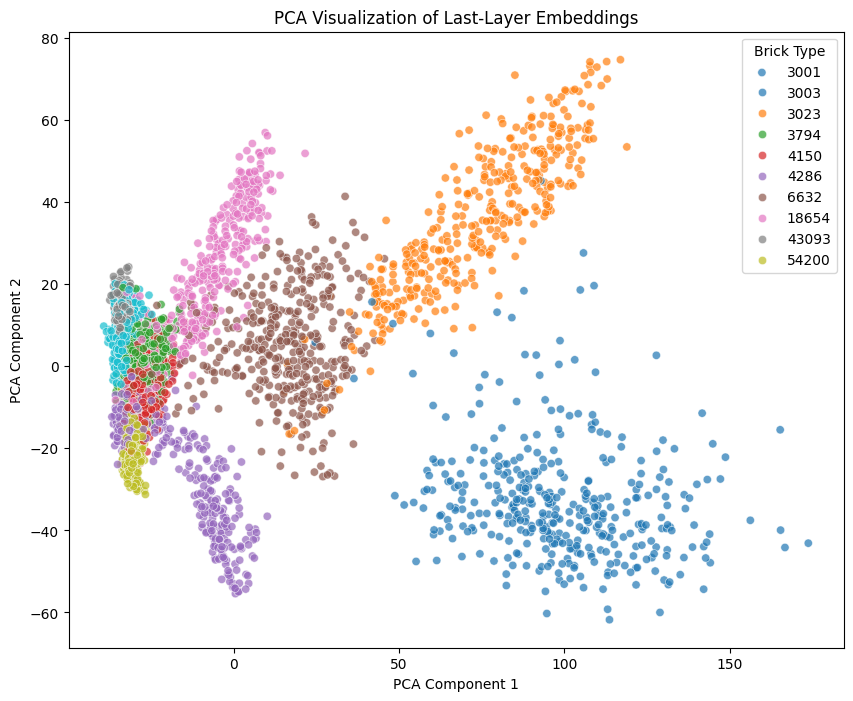

In [8]:
# Extract embeddings for the training set
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.to(device)
        lbls = lbls.argmax(dim=1).cpu().numpy()  # Convert one-hot to class index
        
        output = model(images, return_embedding=True)  # Get last-layer embeddings
        embeddings.append(output.cpu().numpy())
        labels.extend(lbls)

# Convert to numpy arrays
embeddings = np.vstack(embeddings)  # Shape: (num_samples, 128)
labels = np.array(labels)  # Shape: (num_samples,)

np.save("embeddings.npy", embeddings)
np.save("embedding_labels.npy", labels)

# Apply PCA to reduce embeddings to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Plot PCA visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Last-Layer Embeddings")
plt.legend(lego_Y_labels, title="Brick Type")
plt.show()
